<a href="https://colab.research.google.com/github/filbertumbawa15/bio/blob/master/BgWin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
cd '/./content/gdrive/My Drive/Kaggle'

/content/gdrive/My Drive/Kaggle


In [29]:
train_dir = '/content/gdrive/My Drive/Kaggle/DATASET/TRAIN'
test_dir = '/content/gdrive/My Drive/Kaggle/DATASET/TEST'

In [30]:
# import needed libraries
from tensorflow import keras
from keras.applications import EfficientNetB7
from keras.layers import RandomFlip, RandomRotation, GlobalAveragePooling2D, Dropout, Dense
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
from skimage import io
%matplotlib inline

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   validation_split=0.2)


val_datagen = ImageDataGenerator(rescale = 1./255,
                                 validation_split=0.5)

In [8]:
Batch_size = 32

train_set = train_datagen.flow_from_directory(train_dir, class_mode='binary',
                                              batch_size = Batch_size,
                                              target_size=(64, 64))


val_set = val_datagen.flow_from_directory(test_dir, class_mode='binary',
                                          batch_size = Batch_size,
                                          target_size=(64, 64),
                                          subset= 'training')


test_set = val_datagen.flow_from_directory(test_dir, class_mode = 'binary',
                                           batch_size = Batch_size,
                                           target_size=(64, 64),
                                           subset= 'validation')

Found 22564 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.


In [24]:
train_set.class_indices

{'O': 0, 'R': 1}

In [10]:
train_set.image_shape

(64, 64, 3)

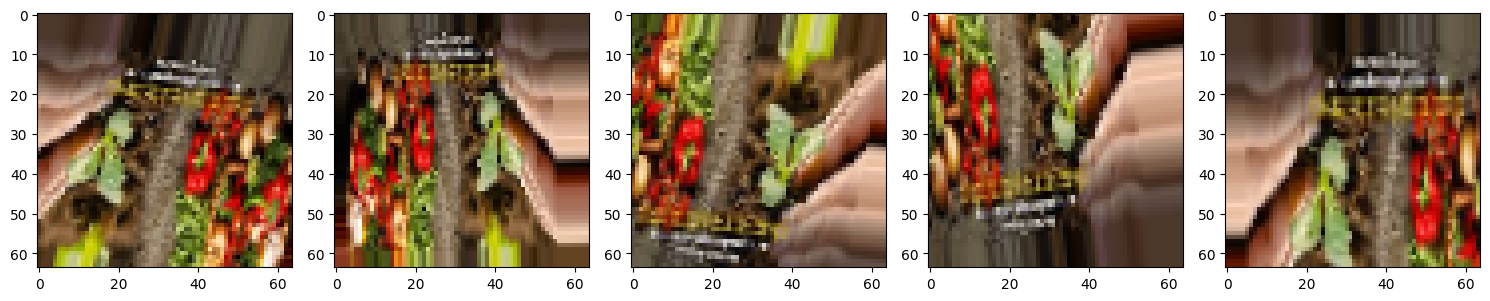

In [11]:
def Images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_img = [train_set[0][0][0] for i in range(5)]
Images(augmented_img)

In [19]:
# use EfficientNet-B7 as base model
base_model = EfficientNetB7(
    input_shape=(64, 64, 3),
    weights='imagenet',
    include_top=False
)
base_model.trainable = False
base_model.summary()

Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 64, 64, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 64)     │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 64)     │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 64)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 64)     │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 64)     │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 64)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [23]:
# modeling
data_augmentation = keras.Sequential(
  [RandomFlip(), RandomRotation(0.2)],
  'augmentation'
)

inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(
  loss='categorical_crossentropy',
  optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Lower learning rate
  metrics=[CategoricalAccuracy(), Precision(), Recall()]
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 2, 2, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │          23,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,120,736 (244.60 MB)

 Trainable params: 23,049 (90.04 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [21]:
# use EarlyStopping callback
es = EarlyStopping(monitor='loss', patience=10)

# use ModelCheckpoint callback
mc_filepath = 'model_checkpoint/best_weights.weights.h5'
mc = ModelCheckpoint(
  filepath=mc_filepath,
  monitor='loss',
  save_best_only=True,
  save_weights_only=True
)

In [22]:
# train model
epochs = 5
history = model.fit(train_set,validation_data=val_set, epochs=epochs, callbacks=[es, mc])

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 9)